# **Battle of the Nieghboorhoods (Week 1)**

## **1. Introduction to the Business Problem**

An eager new chef is looking to establish himself in the Los Angeles culinary scene, but he is not sure which location will be the most successful. Los Angeles has numerous locations with a robust restaurant scene, but data analysis is necessary to chose the correct location. Ensuring the right location could be make it or break it for this this chef and several factors will be considered in the location hunt. According to [The Balance Small Business website](https://www.thebalancesmb.com/choosing-restaurant-location-2888543), there are several pertinent decision making factors. 

1. Visibility - Setting up in  a high foot traffic area. 
2. Size - How big or small is the restaurant going to be. 
3. Neighborhood - This is two pronged, in that who else has a restaurant space as well as the crime statistics in the area. 
4. Affordability - The cost of the lot. 
5. Competitor Analysis - This goes hand in hand with Neighborhood but is important in it's own right. 

In this project, we will use data from the Foursqaure API to address the aforementioned data points. 

## **2. Data**

We will attempt to address all the factors above, but will likely be limited to lack of availability of some data sets. The most important factors, and the ones we will work with will be _Visibility_, _Crime Rates_, and _Pricing_. Competitor analysis will be inherent within the project. 

##### Datasets:

1. Los Angeles Crime data from 2020 to Present - This dataset reflects incidents of crime in the City of Los Angeles dating back to 2020. This data is transcribed from original crime reports that are typed on paper and therefore there may be some inaccuracies within the data. [Link](https://data.lacity.org/A-Safe-City/Crime-Data-from-2020-to-Present/2nrs-mtv8)
2. Los Angeles Neighborhoods - Official Certified Neighborhood Council boundaries in the City of Los Angeles created and maintained by the Bureau of Engineering / GIS Mapping Division. [Link](https://data.lacity.org/A-Well-Run-City/Neighborhoods/ykhe-zspy)
3. Building Permits by Neighborhood - [Link](https://data.lacity.org/A-Prosperous-City/Building-Permits-by-Neighborhood-Council/8dmw-8ykh)

#### Search Engines:

[Foursqaure](https://foursquare.com/). We will use the foursquare API to carry out venue and point of interest search. The results will give us an idea of the neighborhood of the venue's potential location.

# **3. Methodology**

For this project, we will explore Los Angeles Neighborhood and Crime data with the intent to answer the critical factors discussed in the intro. Following that, utilization of the Foursquare API will allow us to explore data within our neighborhoods, providing information on venues and other types of restaurants. The neighborhoods will be clustered using the $k$-mean algorithm. The culminating results will provide potential restaurant locations for our entrepreneurial chef. 

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import pysal as ps
import requests
import os

from pandas.io.json import json_normalize
from geopandas.tools import sjoin
from geopandas import GeoDataFrame
from geopy.geocoders import Nominatim
from folium.plugins import FastMarkerCluster
from shapely.geometry import Point
from sklearn.cluster import KMeans
#from branca.utilities import split_six

%matplotlib inline

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysalnext` package. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


## **3.1 Los Angeles Crime Data Analysis**

 Read the Los Angeles Police Department crime reports and perform our initial checks. 

In [3]:
df_crime = pd.read_csv("Crime_Data_from_2020_to_Present.csv")
df_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61164 entries, 0 to 61163
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DR_NO           61164 non-null  int64  
 1   Date Rptd       61164 non-null  object 
 2   DATE OCC        61164 non-null  object 
 3   TIME OCC        61164 non-null  int64  
 4   AREA            61164 non-null  int64  
 5   AREA NAME       61164 non-null  object 
 6   Rpt Dist No     61164 non-null  int64  
 7   Part 1-2        61164 non-null  int64  
 8   Crm Cd          61164 non-null  int64  
 9   Crm Cd Desc     61164 non-null  object 
 10  Mocodes         53863 non-null  object 
 11  Vict Age        61164 non-null  int64  
 12  Vict Sex        54239 non-null  object 
 13  Vict Descent    54238 non-null  object 
 14  Premis Cd       61163 non-null  float64
 15  Premis Desc     61137 non-null  object 
 16  Weapon Used Cd  22337 non-null  float64
 17  Weapon Desc     22337 non-null 

First five rows of dataset

In [4]:
pd.set_option('display.max_columns', 180)
df_crime.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Used Cd,Weapon Desc,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,10304468,01/08/2020 12:00:00 AM,01/08/2020 12:00:00 AM,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,0444 0913,36,F,B,501.0,SINGLE FAMILY DWELLING,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AO,Adult Other,624,NaN,NaN,NaN,1100 W 39TH PL,NaN,34.0141,-118.2978
1,190101086,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,0416 1822 1414,25,M,H,102.0,SIDEWALK,500.0,UNKNOWN WEAPON/OTHER WEAPON,IC,Invest Cont,624,NaN,NaN,NaN,700 S HILL ST,NaN,34.0459,-118.2545
2,190101087,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,510,1,Central,156,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,1414 1218 2000 1814 0416 0447,53,F,B,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,626,NaN,NaN,NaN,300 E 5TH ST,NaN,34.0449,-118.2458
3,191501505,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),0329 1402,76,F,W,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont,745,998.0,NaN,NaN,5400 CORTEEN PL,NaN,34.1685,-118.4019
4,191921269,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0329,31,X,X,409.0,BEAUTY SUPPLY STORE,NaN,NaN,IC,Invest Cont,740,NaN,NaN,NaN,14400 TITUS ST,NaN,34.2198,-118.4468


## **3.2 Los Angeles Neighborhoods**

To map out the crime data, we will work with neighborhoods,  which is created by the Official Certified Neighborhood Council boundaries in the City of Los Angeles created and maintained by the Bureau of Engineering / GIS Mapping Division. We download the shape file from the website and import it using GeoPandas.

In [5]:
nbrhoods = gpd.read_file('la_neighborhoods.shp')
nbrhoods.head()

,date_certi,time_certi,dwebsite,name,nc_id,objectid,service_re,waddress,geometry
0,2002-04-27,00:00:00.000,http://empowerla.org/LHNC,LINCOLN HEIGHTS NC,47.0,1.0,REGION 8 - NORTH EAST LA,http://www.lincolnheightsnc.org/,"POLYGON ((-118.20503 34.05558, -118.20605 34.0..."
1,2008-06-16,00:00:00.000,https://empowerla.org/voicesof90037/,VOICES OF 90037,109.0,2.0,REGION 9 - SOUTH LA 2,https://www.voicesnc.org,"POLYGON ((-118.28273 34.01114, -118.28234 34.0..."
2,2002-06-11,00:00:00.000,http://empowerla.org/LFNC,LOS FELIZ NC,36.0,3.0,REGION 7 - EAST,http://www.losfeliznc.org/,"POLYGON ((-118.30027 34.15793, -118.29883 34.1..."
3,2005-04-19,00:00:00.000,http://empowerla.org/MHNC,MISSION HILLS NC,101.0,4.0,REGION 1 - NORTH EAST VALLEY,http://mhnconline.org/,"POLYGON ((-118.46933 34.28050, -118.46931 34.2..."
4,2002-09-10,00:00:00.000,http://empowerla.org/GTLNC,GREATER TOLUCA LAKE NC,28.0,5.0,REGION 4 - SOUTH EAST VALLEY,http://www.gtlnc.org/,"POLYGON ((-118.35520 34.16491, -118.35529 34.1..."


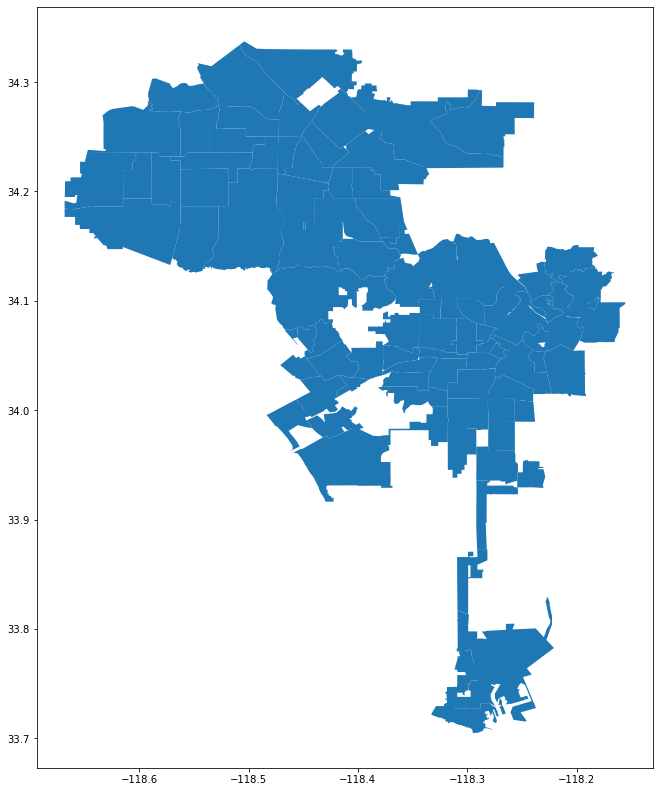

In [6]:
nbrhoods.plot(figsize=(12,14))
plt.show()

## **3.3 Los Angeles Housing Data Analysis**

Import the building permits data and perform initial check. 

In [12]:
df_import = pd.read_csv("Building_Permits_by_Neighborhood_Council.csv")
df_import.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78384 entries, 0 to 78383
Data columns (total 56 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Assessor Book                             78333 non-null  float64
 1   Assessor Page                             78333 non-null  object 
 2   Assessor Parcel                           78333 non-null  object 
 3   Tract                                     77996 non-null  object 
 4   Block                                     15325 non-null  object 
 5   Lot                                       77923 non-null  object 
 6   Reference # (Old Permit #)                39992 non-null  object 
 7   PCIS Permit #                             78384 non-null  object 
 8   Status                                    78384 non-null  object 
 9   Status Date                               78384 non-null  object 
 10  Permit Type                       

We will work with the following columns only.

In [13]:
columns = ['Tract', 
           'Valuation',
           'Latitude/Longitude']

Make sure the data is only for 2020. 

In [14]:
df_housing = df_import[df_import['Assessor Book']==2020.0].loc[:,columns].reset_index(drop=True)

Check if there's any Not a Number cells and drop if necessary.

In [15]:
df_housing.isnull().sum()

Tract                  0
Valuation             54
Latitude/Longitude     3
dtype: int64

In [16]:
df_housing.dropna(inplace=True)
df_housing.isnull().sum()

Tract                 0
Valuation             0
Latitude/Longitude    0
dtype: int64

Computer overall value. 

In [19]:
df_housing['total_price'] = df_housing['Valuation']

In [20]:
df_housing.head()

,Tract,Valuation,Latitude/Longitude,total_price
14,TR 37195,5750.0,"(34.2181, -118.64379)",5750.0
15,TR 36515,3750.0,"(34.2134, -118.63698)",3750.0
17,TR 37195,15000.0,"(34.21779, -118.64479)",15000.0
26,TR 37199,8700.0,"(34.21203, -118.6514)",8700.0
27,TR 26315,10000.0,"(34.2179, -118.63405)",10000.0
